In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Tomato Leaves Dataset",
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Tomato Leaves Dataset",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 10199 files belonging to 10 classes.
Using 7140 files for training.
Found 10199 files belonging to 10 classes.
Using 3059 files for validation.


In [5]:
# MODEL --------------------------------------------------
model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1,
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [6]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
224/224 [==============================] - 28s 95ms/step - loss: 1.5681 - accuracy: 0.4454 - val_loss: 0.9593 - val_accuracy: 0.7231
Epoch 2/200
224/224 [==============================] - 24s 104ms/step - loss: 1.0163 - accuracy: 0.6563 - val_loss: 0.6899 - val_accuracy: 0.7869
Epoch 3/200
224/224 [==============================] - 23s 101ms/step - loss: 0.8234 - accuracy: 0.7158 - val_loss: 0.6418 - val_accuracy: 0.7937
Epoch 4/200
224/224 [==============================] - 23s 100ms/step - loss: 0.7100 - accuracy: 0.7615 - val_loss: 0.5088 - val_accuracy: 0.8398
Epoch 5/200
224/224 [==============================] - 21s 93ms/step - loss: 0.5987 - accuracy: 0.7976 - val_loss: 0.4217 - val_accuracy: 0.8699
Epoch 6/200
224/224 [==============================] - 23s 99ms/step - loss: 0.5204 - accuracy: 0.8154 - val_loss: 0.4207 - val_accuracy: 0.8647
Epoch 7/200
224/224 [==============================] - 27s 120ms/step - loss: 0.5095 - accuracy: 0.8251 - val_loss: 0.3936 - va

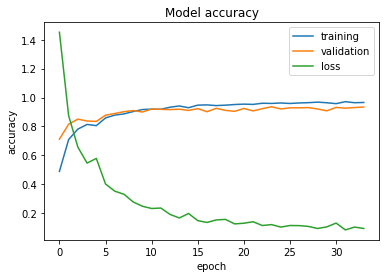

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 85ms/step
              precision    recall  f1-score   support

           0     0.8731    0.8975    0.8851       322
           1     0.8962    0.9283    0.9120       279
           2     0.9485    0.9720    0.9601       322
           3     0.9254    0.9254    0.9254       295
           4     0.9346    0.9256    0.9301       309
           5     0.8703    0.8900    0.8800       309
           6     0.9799    0.9733    0.9766       300
           7     0.9832    0.9361    0.9591       313
           8     0.9734    0.9544    0.9638       307
           9     0.9864    0.9604    0.9732       303

    accuracy                         0.9363      3059
   macro avg     0.9371    0.9363    0.9365      3059
weighted avg     0.9372    0.9363    0.9365      3059



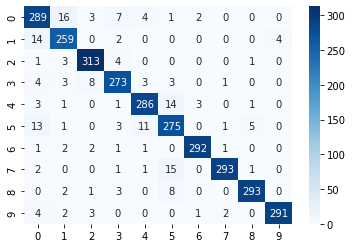

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

epochs = 1

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)


58889256/58889256 [==============================] - 3s 0us/step


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


224/224 [==============================] - 30s 123ms/step - loss: 0.2106 - binary_accuracy: 0.9331 - val_loss: 0.1265 - val_binary_accuracy: 0.9539


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/Colab Notebooks/datasets/Tomato Leaves Dataset/healthy/9c3ad610-7677-4f3c-9646-88069e0c61cb___GH_HL Leaf 449.2.JPG", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

result = ["Early_blight","Late_blight","Leaf_Mold","Septoria_leaf_spot","Spider_mites Two-spotted_spider_mite","Target_Spot","Tomato_Yellow_Leaf_Curl_Virus","Tomato_mosaic_virus","healthy","powdery_mildew"]

print(result[np.argmax(predictions[0])])

1/1 [==============================] - 0s 19ms/step
healthy


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0     0.6918    0.6379    0.6638       359
           1     0.7889    0.7972    0.7930       286
           2     0.7242    0.8328    0.7747       287
           3     0.6305    0.7323    0.6776       254
           4     0.6732    0.8340    0.7450       247
           5     0.7247    0.6123    0.6638       374
           6     0.9497    0.8654    0.9056       327
           7     0.8893    0.9464    0.9170       280
           8     0.8704    0.7616    0.8124       344
           9     0.9525    0.9336    0.9430       301

    accuracy                         0.7872      3059
   macro a

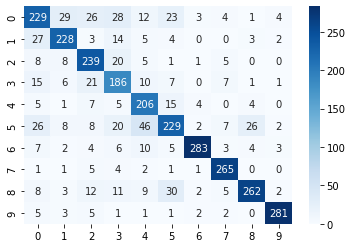

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for x, y in val_ds:
  print(len(y))

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))